# Summary Criterion for Epistasis 

© 2018 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [96]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy 
import bokeh.io
import mut.stats
import mut.thermo
import mut.viz
colors = mut.viz.color_selector('mut')
constants = mut.thermo.load_constants()
mut.viz.plotting_style()

sympy.init_printing()
bokeh.io.output_notebook()

Loading BokehJS ...

We are looking for aa useful criterior for understanding and summarizing the degree of epistasis for a given mutant. A useful quantity is the Bohr parameter, which for a given mutant is defined as 

$$
F = k_BT \left(\log p_{act}(c) + \log {R \over N_{NS}} - {\Delta\varepsilon_{RA}\over k_BT}\right) \tag{1},
$$

where $p_{act}(c)$ is the probability of a repressor being in the active state at an inducer concentration $c$. This quantity is defined as 

$$
p_{act}(c) = {\left(1 + {c \over K_A}\right)^n \over \left(1 + {c \over K_A}\right)^n + e^{-\beta\Delta\varepsilon_{AI}}\left(1 + {c \over K_I}\right)^2 }. \tag{2}
$$

We can summarize the change in the Bohr parameter (which can also be interepreted as the free energy) at a given inducer concentration $c$ relative to the wild type repressor as

$$
\Delta F = k_BT \left[ \log {p_{act}^{mut}(c) \over p_{act}^{wt}(c)}  - \left(\Delta\varepsilon_{RA}^{mut} - \Delta\varepsilon_{RA}^{wt}\over k_BT \right)\right]. \tag{3}
$$

Immediately we see the intriguing separation between teh two domains of the repressor with the $p_{act}(c)$ ratio describing changes to the inducer binding domain (and allosteric communication channel) and the DNA binding domain by the $\Delta\Delta\varepsilon_{RA}$. but this is all foragiven concentration of inducer. The $\Delta F$ will change drastically depending on what $c$ we choose. We would like some way in which we can describe the overall effect.  


The separation of these two domains gets at the heart of the epistasis. In general, we can say that the total free energy of the interaction is a simple sum of the free energies of the individual mutants,

$$
\Delta F_{dbl}(c) = \Delta F_{dna}(c) + \Delta F_{ind}(c) \tag{4}.
$$

If there is epistasis, there is another term added to Eq. 4,

$$
\Delta F_{dbl}(c)= \Delta F_{dna}(c) + \Delta F_{ind}(c) + \varepsilon_{epistasis}(c). \tag{5}.
$$

(I think). 

In [238]:
# Load the sampling information for all double mutants
KaKi_summary = pd.read_csv('../../data/csv/KaKi_only_summary.csv')
KaKi_samples = pd.read_csv('../../data/csv/KaKi_only_samples.csv')
KaKi_epAI_summary = pd.read_csv('../../data/csv/KaKi_epAI_summary.csv')
KaKi_epAI_samples = pd.read_csv('../../data/csv/KaKi_epAI_samples.csv')
epRA_summary = pd.read_csv('../../data/csv/DNA_binding_energy_summary.csv')
epRA_samples = pd.read_csv('../../data/csv/DNA_binding_energy_samples.csv')

# Load the raw data. 
data = pd.read_csv('../../data/csv/compiled_data.csv')

# Define the mutants
DNA_mutants = ['Y20I', 'Q21M', 'Q21A']
IND_mutants = ['Q294K', 'F164T', 'Q294V']

# Define the range of inducer concentrations we want to look over. 
c_range = data['IPTGuM'].unique()

arch = mut.thermo.SimpleRepression(R=260, ep_r=constants['O2'], n_ns=constants['Nns'],
                                     ep_ai=constants['ep_AI'], ka=constants['Ka'],
                                     ki=constants['Ki'], effector_conc=c_range,
                                     n_sites=constants['n_sites'])
bohr_wt = arch.bohr_parameter()
ec50 = arch.ec50()


p = bokeh.plotting.figure(width=600, height=400, 
                         x_axis_label='predicted Bohr', y_axis_label='measured Bohr')


p2 = bokeh.plotting.figure(x_axis_type='log')
p2.line(c_range, bohr_wt, color='black', line_dash='dotted', legend='wt')


# Loop through each mutant. 
dfs = []
for i, dna in enumerate(DNA_mutants):
    epRA = epRA_summary[(epRA_summary['mutant']==dna) & (epRA_summary['operator']=='O2') &
                    (epRA_summary['repressors']==260) & (epRA_summary['parameter']=='ep_RA')]['mode'].values[0]

    epRA_samps = epRA_samples[(epRA_samples['mutant']==dna) & (epRA_samples['operator']=='O2') &    
                    (epRA_samples['repressors']==260)]['ep_RA']
    for j, ind in enumerate(IND_mutants):
        if (dna =='Y20I') and (ind == 'Q294K'):
            pass
        else:
            mutant = f'{dna}-{ind}'
            _data = data[(data['mutant']==f'{dna}-{ind}') & (data['operator']=='O2') & (data['repressors']==260)]
            c_range = _data['IPTGuM']
            if ind == 'Q294K':
                _kaki_summary = KaKi_epAI_summary
                _kaki_samples = KaKi_epAI_samples
                epAI = KaKi_epAI_summary[(KaKi_epAI_summary['operator']=='O2') & 
                                        (KaKi_epAI_summary['mutant']=='Q294K') &
                                         (KaKi_epAI_summary['parameter']=='ep_AI')]['mode'].values[0]
            else:
                _kaki_summary = KaKi_summary
                _kaki_samples = KaKi_samples
                _kaki_samples['ep_AI'] = constants['ep_AI']
                epAI = constants['ep_AI']
                
            # Extract the mutant properties. 
            Ka = _kaki_summary[(_kaki_summary['mutant']==ind) & (_kaki_summary['operator']=='O2') &
                  (_kaki_summary['parameter']=='Ka')]['mode'].values[0]
            Ka_samps = _kaki_samples[(_kaki_samples['mutant']==ind) & (_kaki_samples['operator']=='O2')]['Ka']
            Ki = _kaki_summary[(_kaki_summary['mutant']==ind) & (_kaki_summary['operator']=='O2') &
                  (_kaki_summary['parameter']=='Ki')]['mode'].values[0]
            Ki_samps = _kaki_samples[(_kaki_samples['mutant']==ind) & (_kaki_samples['operator']=='O2')]['Ki']
            epAI_samps = _kaki_samples[(_kaki_samples['mutant']==ind) & (_kaki_samples['operator']=='O2')]['ep_AI']
             
            # Define the IPTG range and compute the pact ratio
            arch_mut = mut.thermo.SimpleRepression(R=260, ep_r=epRA, n_ns=constants['Nns'],
                                              ep_ai=epAI, n_sites=constants['n_sites'],
                                              ka=Ka, ki=Ki, effector_conc=c_range)
        
            bohr_mut = arch_mut.bohr_parameter()
            cred_region = np.zeros((2, len(c_range)))
            for k, c in enumerate(c_range):
                arch_mut = mut.thermo.SimpleRepression(R=260, ep_r=epRA_samps, n_ns=constants['Nns'],
                                              ep_ai=epAI_samps, n_sites=constants['n_sites'],
                                              ka=Ka_samps, ki=Ki_samps, effector_conc=c).bohr_parameter()
                cred_region[:, k] = mut.stats.compute_hpd(arch_mut,0.95)
                
            bohr_meas = -np.log((1 / _data['fold_change']) - 1)
               
            arch = mut.thermo.SimpleRepression(R=260, ep_r=constants['O2'], n_ns=constants['Nns'],
                                     ep_ai=constants['ep_AI'], ka=constants['Ka'],
                                     ki=constants['Ki'], effector_conc=c_range,
                                     n_sites=constants['n_sites'])
            bohr_wt = arch.bohr_parameter()
        
            # Given the data, compute interaction energy
            
            _df = pd.DataFrame([])           
            _df['deltaF_meas'] = bohr_meas - bohr_wt
            _df['deltaF_pred'] = bohr_mut - bohr_wt 
            _df['deltaF_pred_min'] = cred_region[0, :] - bohr_wt
            _df['deltaF_pred_max'] = cred_region[1, :] - bohr_wt
            _df['bohr_wt'] = bohr_wt
            _df['bohr_mut'] = bohr_mut
            _df['bohr_meas'] = bohr_meas
            _df['ep_int'] = bohr_meas - bohr_mut
            _df['fold_change'] = _data['fold_change']
            _df['IPTGuM'] = c_range 
            _df['mutant'] = f'{dna}-{ind}'
            dfs.append(_df)
            
df = pd.concat(dfs, sort=False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in log


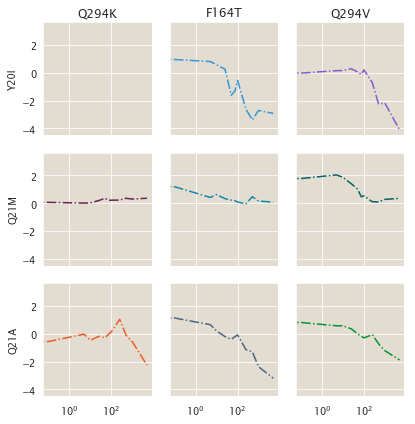

In [242]:
# Plot the grid matrix
fig, ax = plt.subplots(3, 3, figsize=(6,6), sharex=True, sharey=True)
# dbohr_range = np.linspace(-8, 8, 500)
for a in ax.ravel():
    a.set_xscale('log')
#     a.set_xlim([-8, 8])
    
for i, dna in enumerate(DNA_mutants):
    ax[i, 0].set_ylabel(dna)
    for j, ind in enumerate(IND_mutants):
        ax[0, j].set_title(ind)
        # Define the mutant. 
        mutant = f'{dna}-{ind}'
        
        if mutant != 'Y20I-Q294K':
            
            # Isolate the data. 
            _df = df[(df['mutant']==mutant)].groupby(['IPTGuM']).mean().reset_index()
            
            
            # Plot the master curve
#             ax[i, j].plot(dbohr_range, dbohr_range, 'k-', lw=1)
            
            # Plot the data and predicted value. 
            ax[i, j].plot(_df['IPTGuM'], _df['ep_int'], '-.',
                         color=colors[mutant])
#             ax[i, j].hlines(_df['bohr_mut'], _df['bohr_meas'], _df['deltaF_pred_max'], lw=1,
#                          color=colors[mutant])           
#             # Plot the corrected value
#             ax[i, j].errorbar(grouped['bohr_mut'] + np.mean(_df['ep_int']), grouped['mean'], grouped['sem'],
#                           fmt='o', linestyle='none', ms=4, color=colors[mutant], 
#                           markerfacecolor='w')
            
   
plt.tight_layout()
# plt.savefig('/Users/gchure/Desktop/gridmat.pdf')

In [232]:
_df.reset_index()

IPTGuM deltaF_meas           deltaF_pred               deltaF_pred_min  \
                  mean       sem        mean           sem            mean   
0      0.0    4.610100       NaN    2.817405  8.709306e-17             NaN   
1      0.1    3.616329  0.225853    2.813569  0.000000e+00             NaN   
2      5.0    2.694065  0.119755    2.129189  0.000000e+00             NaN   
3     10.0    1.969094  0.039730    1.405339  0.000000e+00             NaN   
4     25.0    0.756432  0.151982    0.405593  0.000000e+00             NaN   
5     50.0    0.025572  0.102282    0.043806  0.000000e+00             NaN   
6     75.0   -0.136342  0.159984    0.038837  0.000000e+00             NaN   
7    100.0   -0.196278  0.156595    0.111110  0.000000e+00             NaN   
8    250.0    0.542690  0.296174    0.607264  0.000000e+00             NaN   
9    500.0    0.361503  0.351373    1.085204  0.000000e+00             NaN   
10  1000.0    0.288931  0.201324    1.511007  0.000000e+00             NaN   
11  5000.0    0.173665  0.671655    2.059722  0.000000e+00             NaN   

       deltaF_pred_max       bohr_wt       bohr_mut               bohr_meas  \
   sem            mean sem      mean  sem      mean           sem      mean   
0  NaN             NaN NaN -4.108067  0.0 -1.290662  4.354653e-17  0.502033   
1  NaN             NaN NaN -4.103562  0.0 -1.289994  0.000000e+00 -0.487233   
2  NaN             NaN NaN -3.364458  0.0 -1.235269  0.000000e+00 -0.670393   
3  NaN             NaN NaN -2.547119  0.0 -1.141780  0.000000e+00 -0.578025   
4  NaN             NaN NaN -1.147838  0.0 -0.742244  0.000000e+00 -0.391406   
5  NaN             NaN NaN -0.100626  0.0 -0.056820  0.000000e+00 -0.075055   
6  NaN             NaN NaN  0.447149  0.0  0.485986  0.000000e+00  0.310807   
7  NaN             NaN NaN  0.794945  0.0  0.906054  0.000000e+00  0.598667   
8  NaN             NaN NaN  1.642739  0.0  2.250003  0.000000e+00  2.185429   
9  NaN             NaN NaN  2.033247  0.0  3.118450  3.140185e-16  2.394750   
10 NaN             NaN NaN  2.262043  0.0  3.773050  0.000000e+00  2.550973   
11 NaN             NaN NaN  2.466342  0.0  4.526064  0.000000e+00  2.640006   

             fold_change            
         sem        mean       sem  
0        NaN    0.585167  0.050330  
1   0.225853    0.383418  0.052456  
2   0.119755    0.339409  0.027119  
3   0.039730    0.359490  0.009135  
4   0.151982    0.404445  0.036379  
5   0.102282    0.481378  0.025429  
6   0.159984    0.576272  0.039252  
7   0.156595    0.643839  0.036430  
8   0.296174    0.892430  0.029028  
9   0.351373    0.908441  0.028698  
10  0.201324    0.925232  0.014517  
11  0.671655    0.911754  0.036761

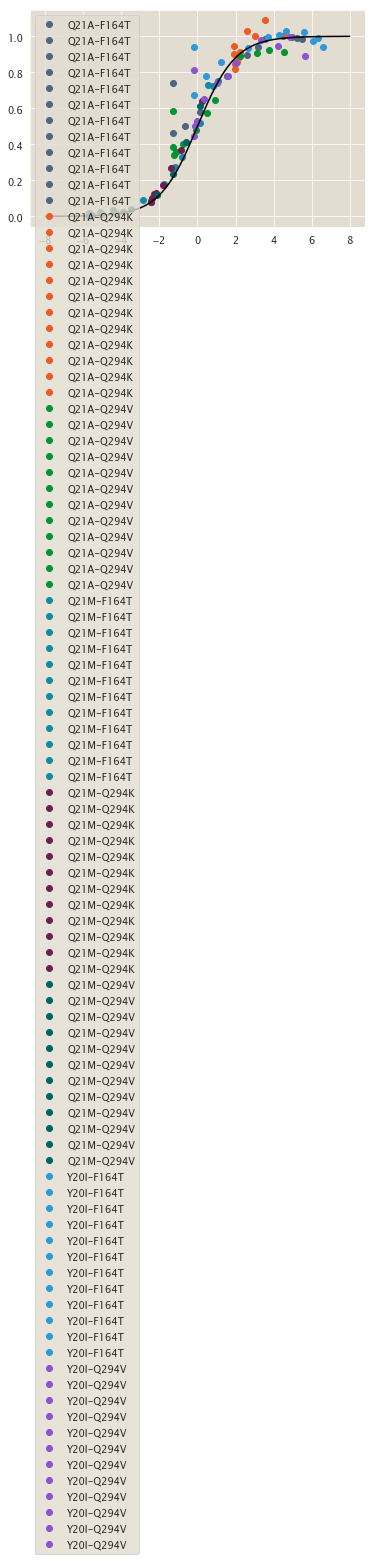

In [225]:
for g, d in df.groupby(['mutant','IPTGuM']):
    plt.plot(d['bohr_mut'].mean(), d['fold_change'].mean(), 'o', color=colors[g[0]], label=g[0])
   
bohr_range= np.linspace(-8, 8, 300)
plt.plot(bohr_range, 1 / (1 + np.exp(-bohr_range)), 'k-')
plt.legend()



One option is to integrate Eq. 3 over all $c$, which is worth looking at (although I don't think the integral will converge). Another option is to take the worst case scenario, when $\Delta F$ is maximized. This can be stated mathematically as 

$$
{\partial \Delta F \over \partial c} \bigg\vert_{c=c^*} = 0. \tag{4}
$$

The $p_{act}(c)$ ratio is pretty gnarly, 

$$
{p_{act}^{mut}(c) \over p_{act}^{wt}(c)} = \left[{1 + {c \over K_A^{mut}} \over 1 + {c \over K_A^{wt}}}\right]^n\left[{1 + e^{-\beta\Delta\varepsilon_{AI}^{wt}}\left({1 + {c \over K_I^{wt}}\over 1 + {c \over K_A^{wt}}}\right)^n \over 1 + e^{-\beta\Delta\varepsilon_{AI}^{mut}}\left({1 + {c\over K_I^{mut}} \over 1 + {c \over K_A^{mut}}}\right)^n}\right]. \tag{5}
$$

This is a bit too hardcore to do manually. Before we try to do compute this using symbolic computing (which may not be able to solve it), we can look at the profile numerically. 

In [125]:
# Load the sampling information for all double mutants
KaKi_summary = pd.read_csv('../../data/csv/KaKi_only_summary.csv')
KaKi_epAI_summary = pd.read_csv('../../data/csv/KaKi_epAI_summary.csv')
epRA_summary = pd.read_csv('../../data/csv/DNA_binding_energy_summary.csv')

# Load the raw data. 
data = pd.read_csv('../../data/csv/compiled_data.csv')

# Define the mutants
DNA_mutants = ['Q21M', 'Y20I', 'Q21A']
IND_mutants = ['F164T', 'Q294K', 'Q294V']

# Define the range of inducer concentrations we want to look over. 
c_range = data['IPTGuM'].unique()

arch = mut.thermo.SimpleRepression(R=260, ep_r=constants['O2'], n_ns=constants['Nns'],
                                     ep_ai=constants['ep_AI'], ka=constants['Ka'],
                                     ki=constants['Ki'], effector_conc=c_range,
                                     n_sites=constants['n_sites'])
bohr_wt = arch.bohr_parameter()
ec50 = arch.ec50()

# Plot the delta F as a function of the inducer concentration
p = bokeh.plotting.figure(width=600, height=400, x_axis_type='log', y_axis_type='log',
                         x_axis_label='IPTG [µM]', y_axis_label='ΔF (kT) / Fwt')

vline = bokeh.models.Span(location=ec50, dimension='height', line_color='black', line_width=2, line_dash='dotted')
p.renderers.extend([vline])

p2 = bokeh.plotting.figure(x_axis_type='log')
p2.line(c_range, bohr_wt, color='black', line_dash='dotted', legend='wt')


# Loop through each mutant. 
dfs = []
for i, dna in enumerate(DNA_mutants):
    epRA = epRA_summary[(epRA_summary['mutant']==dna) & (epRA_summary['operator']=='O2') &
                    (epRA_summary['repressors']==260) & (epRA_summary['parameter']=='ep_RA')]['mode'].values[0]
    for j, ind in enumerate(IND_mutants):
        if (dna =='Y20I') and (ind == 'Q294K'):
            pass
        else:
            _data = data[(data['mutant']==f'{dna}-{ind}') & (data['operator']=='O2') & (data['repressors']==260)]
            c_range = _data['IPTGuM']
            if ind == 'Q294K':
                _kaki_summary = KaKi_epAI_summary
                epAI = KaKi_epAI_summary[(KaKi_epAI_summary['operator']=='O2') & 
                                        (KaKi_epAI_summary['mutant']=='Q294K') &
                                         (KaKi_epAI_summary['parameter']=='ep_AI')]['mode'].values[0]
            else:
                _kaki_summary = KaKi_summary
                epAI = constants['ep_AI']
            # Extract the mutant properties. 
            Ka = _kaki_summary[(_kaki_summary['mutant']==ind) & (_kaki_summary['operator']=='O2') &
                  (_kaki_summary['parameter']=='Ka')]['mode'].values[0]
            Ki = _kaki_summary[(_kaki_summary['mutant']==ind) & (_kaki_summary['operator']=='O2') &
                  (_kaki_summary['parameter']=='Ki')]['mode'].values[0]

            # Define the IPTG range and compute the pact ratio
            bohr_mut = mut.thermo.SimpleRepression(R=260, ep_r=epRA, n_ns=constants['Nns'],
                                              ep_ai=epAI, n_sites=constants['n_sites'],
                                              ka=Ka, ki=Ki, effector_conc=c_range).bohr_parameter()
            
            # Given the data, compute interaction energy

            ep_int = -np.log((1 /_data['fold_change']) - 1) - bohr_mut
            
            _df = pd.DataFrame([])           
            _df['ep_int'] = ep_int
            _df['IPTGuM'] = _data['IPTGuM']
            _df['mutant'] = f'{dna}-{ind}'
            _df['bohr_mut'] = bohr_mut
            _df['fold_change'] = _data['fold_change']
            dfs.append(_df)
            
df = pd.concat(dfs, sort=False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in log


In [119]:
grouped = df.groupby('mutant')
p = bokeh.plotting.figure(width=500, height=300, x_axis_label='epistatic interaction energy [kT]')
for g, d in grouped:
    # Compute the ecdf. 
    x, y = np.sort(d['ep_int']), np.arange(0, len(d)) / len(d)
    p.circle(x, y, color=colors[g], legend=g)
    p.step(x, y, color=colors[g])

    
bokeh.io.show(p)

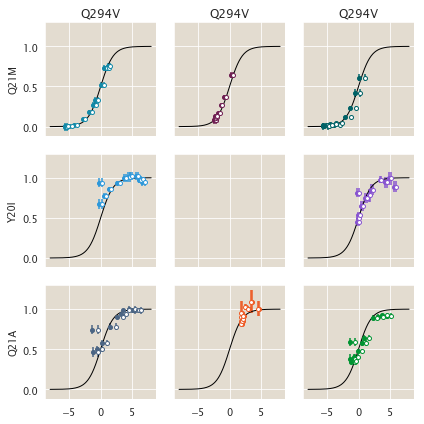

In [124]:
# Plot the grid matrix
fig, ax = plt.subplots(3, 3, figsize=(6,6), sharex=True, sharey=True)
bohr_range = np.linspace(-8, 8, 500)
master_curve = 1 / (1 + np.exp(-bohr_range))

for i, dna in enumerate(DNA_mutants):
    ax[i, 0].set_ylabel(dna)
    for j, ind in enumerate(IND_mutants):
        ax[0, i].set_title(ind)
        # Define the mutant. 
        mutant = f'{dna}-{ind}'
        
        if mutant != 'Y20I-Q294K':
            
            # Isolate the data. 
            _df = df[(df['mutant']==mutant)]
            grouped = _df.groupby(['bohr_mut']).apply(mut.stats.compute_mean_sem).reset_index()
            
            # Plot the master curve
            ax[i, j].plot(bohr_range, master_curve, 'k-', lw=1)
            
            # Plot the data and predicted value. 
            ax[i, j].errorbar(grouped['bohr_mut'], grouped['mean'], grouped['sem'],
                          fmt='o', linestyle='none', ms=4, color=colors[mutant])
            
            # Plot the corrected value
            ax[i, j].errorbar(grouped['bohr_mut'] + np.mean(_df['ep_int']), grouped['mean'], grouped['sem'],
                          fmt='o', linestyle='none', ms=4, color=colors[mutant], 
                          markerfacecolor='w')
            
   
plt.tight_layout()
plt.savefig('/Users/gchure/Desktop/gridmat.pdf')

In [107]:
mutant

'Y20I-Q294K'

## Symbolic Computing

In [53]:
# Architectural parameters
epRA_mut = sympy.Symbol(r'\Delta\varepsilon_{RA}^{mut}')
epRA_wt = sympy.Symbol(r'\Delta\varepsilon_{RA}^{wt}')
R_Nns = sympy.Symbol(r'\frac{R}{N_{NS}}')
# Allosteric parameters
epAI_mut = sympy.Symbol(r'\Delta\varepsilon_{AI}^{mut}')
epAI_wt = sympy.Symbol(r'\Delta\varepsilon_{AI}^{wt}')
Ka_mut = sympy.Symbol('K_A^{mut}')
Ka_wt = sympy.Symbol('K_A^{wt}')
Ki_mut = sympy.Symbol('K_i^{mut}')
Ki_wt = sympy.Symbol('K_i^{wt}')
n = sympy.Symbol('n')
c = sympy.Symbol('c')

# And finally, the dimensional constant. 
k_BT = sympy.Symbol(r'k_BT')

# Define the pacts
mut_pact = (1 + sympy.exp())

# Define the allosteric inactive state term 
wt_numer = (1 + sympy.exp(epAI_wt) * (wt_inactive_states)/(wt_active_states))
mut_denom = (1 + sympy.exp(epAI_mut) * (mut_inactive_states) / (mut_active_states))

# Define the p_act ratio
pact_ratio = (mut_active_states / wt_active_states) * (wt_numer / mut_denom)

# Compute the ΔF.
delta_f = (sympy.log(pact_ratio) - (epRA_mut - epRA_wt))

# Define the Bohr for the wild-type
wt_bohr = sympy.log(wt_active_states / (wt_active_states + sympy.exp(-epAI_wt) * wt_inactive_states)) + sympy.log(R_Nns) - epRA_wt

bohr_effect = delta_f / wt_bohr
bohr_effect.diff(c).simplify()

KeyboardInterrupt: 

In [5]:
diff = delta_f.diff(c)

In [6]:
sympy.simplify(diff)

  ⎛                  n                                                        
  ⎜  ⎛K_i__{mut} + c⎞                                                         
n⋅⎜- ⎜──────────────⎟ ⋅(K_A__{mut} - K_i__{mut})⋅(K_A__{wt} + c)⋅(K_i__{wt} + 
  ⎝  ⎝  K_i__{mut}  ⎠                                                         
                                                                              
                                                                              
                                                                              
                                                                              
                                                                              
                                                                              
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                    

In [7]:
sympy.solvers.solve(sympy.Eq(diff, 0), c, positive=True)

NotImplementedError: multiple generators [c, (1 + c/K_A^{mut})**n, (1 + c/K_A^{wt})**n, (1 + c/K_i^{mut})**n, (1 + c/K_i^{wt})**n]
No algorithms are implemented to solve equation (1 + c/K_A^{mut})**n*(1 + c/K_A^{wt})**(-n)*(n*(1 + c/K_A^{wt})**(-n)*(1 + c/K_i^{wt})**n*exp(\Delta\varepsilon_{AI}^{wt})/(K_i^{wt}*(1 + c/K_i^{wt})) - n*(1 + c/K_A^{wt})**(-n)*(1 + c/K_i^{wt})**n*exp(\Delta\varepsilon_{AI}^{wt})/(K_A^{wt}*(1 + c/K_A^{wt})))/(1 + (1 + c/K_A^{mut})**(-n)*(1 + c/K_i^{mut})**n*exp(\Delta\varepsilon_{AI}^{mut})) + (1 + c/K_A^{mut})**n*(1 + c/K_A^{wt})**(-n)*(1 + (1 + c/K_A^{wt})**(-n)*(1 + c/K_i^{wt})**n*exp(\Delta\varepsilon_{AI}^{wt}))*(-n*(1 + c/K_A^{mut})**(-n)*(1 + c/K_i^{mut})**n*exp(\Delta\varepsilon_{AI}^{mut})/(K_i^{mut}*(1 + c/K_i^{mut})) + n*(1 + c/K_A^{mut})**(-n)*(1 + c/K_i^{mut})**n*exp(\Delta\varepsilon_{AI}^{mut})/(K_A^{mut}*(1 + c/K_A^{mut})))/(1 + (1 + c/K_A^{mut})**(-n)*(1 + c/K_i^{mut})**n*exp(\Delta\varepsilon_{AI}^{mut}))**2 - n*(1 + c/K_A^{mut})**n*(1 + c/K_A^{wt})**(-n)*(1 + (1 + c/K_A^{wt})**(-n)*(1 + c/K_i^{wt})**n*exp(\Delta\varepsilon_{AI}^{wt}))/(K_A^{wt}*(1 + c/K_A^{wt})*(1 + (1 + c/K_A^{mut})**(-n)*(1 + c/K_i^{mut})**n*exp(\Delta\varepsilon_{AI}^{mut}))) + n*(1 + c/K_A^{mut})**n*(1 + c/K_A^{wt})**(-n)*(1 + (1 + c/K_A^{wt})**(-n)*(1 + c/K_i^{wt})**n*exp(\Delta\varepsilon_{AI}^{wt}))/(K_A^{mut}*(1 + c/K_A^{mut})*(1 + (1 + c/K_A^{mut})**(-n)*(1 + c/K_i^{mut})**n*exp(\Delta\varepsilon_{AI}^{mut})))

In [171]:
DBL_epAI_summary

,parameter,mode,hpd_min,hpd_max,repressors,mutant,operator
0,ep_AI,-2.265459,-3.138093,-1.643232,260.0,Q21A-F164T,O2
1,sigma,0.281132,0.221930,0.387835,260.0,Q21A-F164T,O2
2,lp__,19.853612,16.479463,19.853612,260.0,Q21A-F164T,O2
3,ep_AI,-3.482162,-5.092440,-2.779999,260.0,Q21A-Q294K,O2
4,sigma,0.138117,0.107355,0.193570,260.0,Q21A-Q294K,O2
5,lp__,38.371947,33.769033,38.371947,260.0,Q21A-Q294K,O2
6,ep_AI,-1.434799,-1.978990,-0.858339,260.0,Q21A-Q294V,O2
7,sigma,0.260778,0.200826,0.354944,260.0,Q21A-Q294V,O2
8,lp__,21.827596,18.680295,21.827596,260.0,Q21A-Q294V,O2
9,ep_AI,0.773112,-3.383800,19.159317,260.0,Q21M-F164T,O2
